In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import LogNorm
import sys
import datetime
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger

np.random.seed(42)

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device= "cpu"
print('device used in training:', device)

device used in training: cuda:0


# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

In [3]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,n_s)
u_ = np.random.uniform(0,1,n_b)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

In [4]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) 

# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train[::,1:].astype('float32'),y_train.astype('int32'),x_train[::,0].astype('float32'))
valdataset = DataSet(x_val[::,1:].astype('float32'),y_val.astype('int32'),x_val[::,0].astype('float32'))
testTensor= torch.from_numpy(x_test[::,1:]).float().to(device)

In [5]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])
now = datetime.datetime.now().strftime("%m-%d_%H-%M")

params = {'epochs'       : 300,
          'interval'     : 100,
          'batch_size'   : 4096,
          'shuffle'      : True,
          'num_workers'  : 6,
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }
logger = Logger(f"./log/logTest({now}).txt",overwrite=False)

Entering Training...
Epoch:0001/0100  (0.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2511, acc:50%, R50: 1.9911, 1/JSD: 584.8246
Epoch:0100/0100  (82.9 s)
 Train: loss:0.1650, acc:77% || Val: loss: 0.1625, acc:78%, R50: 11.1837, 1/JSD: 89.6465


/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


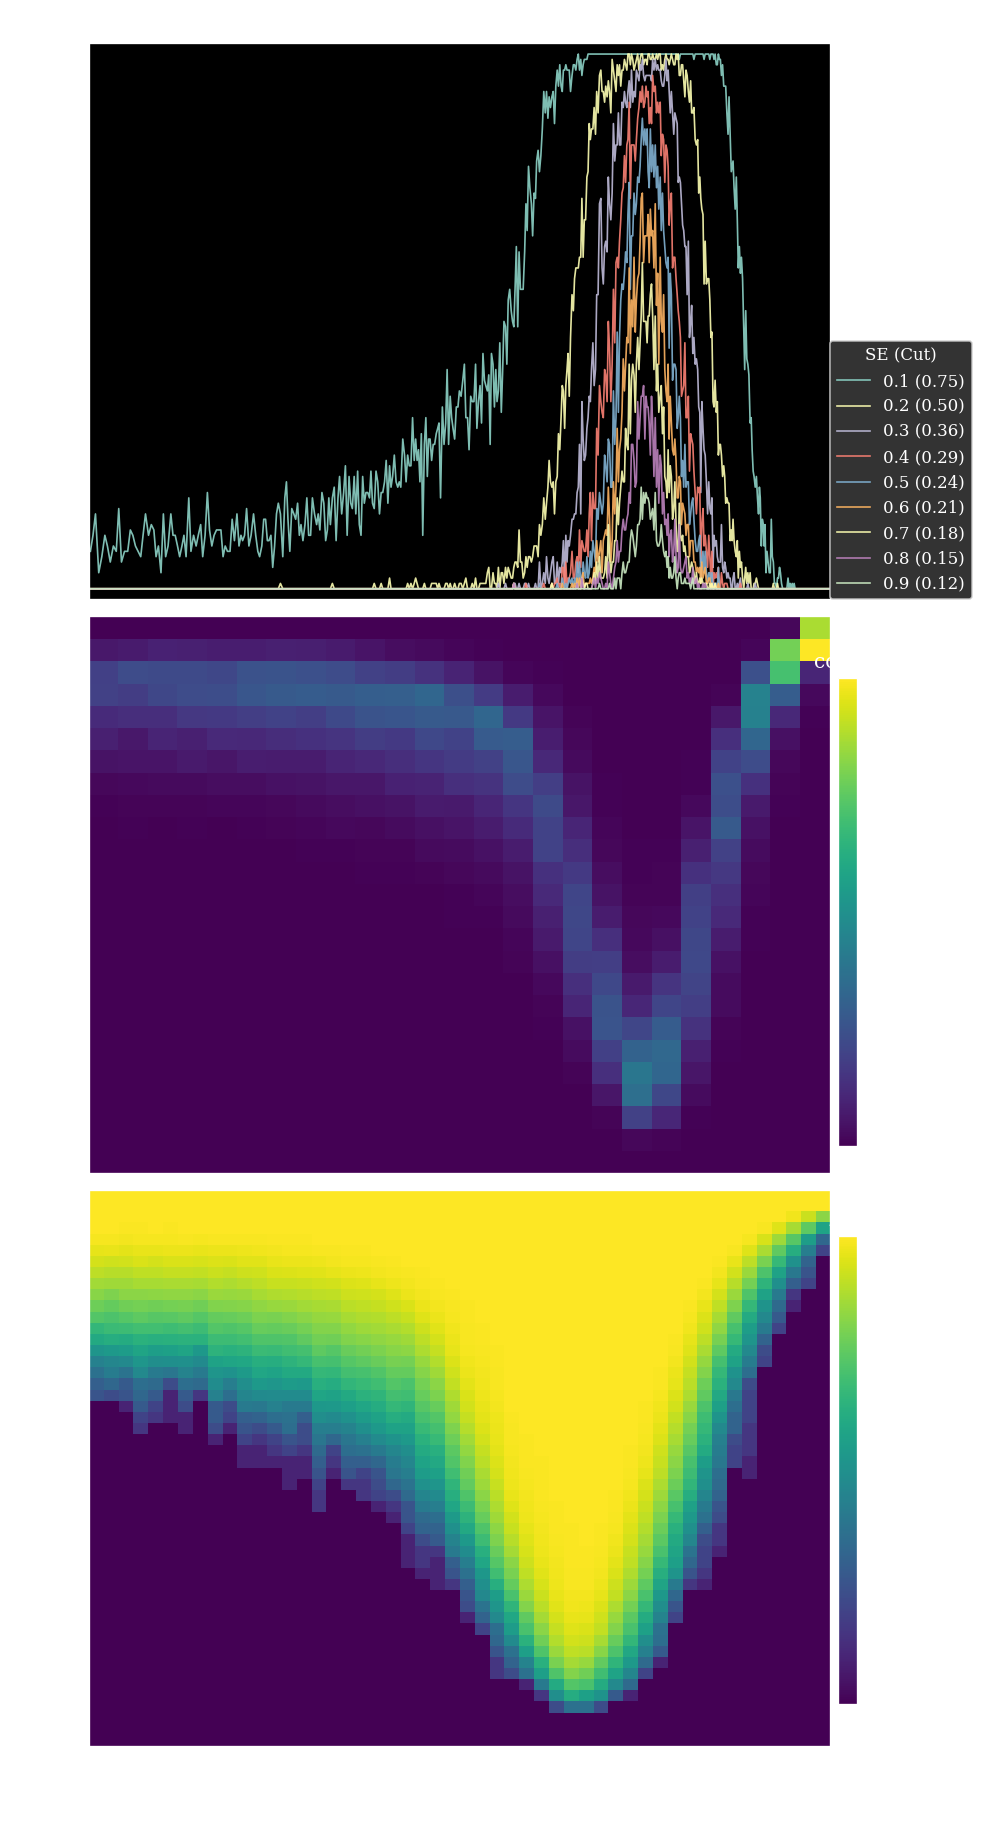

Entering Training...
Epoch:0001/0100  (0.4  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2503, acc:50%, R50: 1.8066, 1/JSD: 932.4912
Epoch:0100/0100  (80.5 s)
 Train: loss:0.2016, acc:79% || Val: loss: 0.1850, acc:77%, R50: 11.5437, 1/JSD: 100.2412


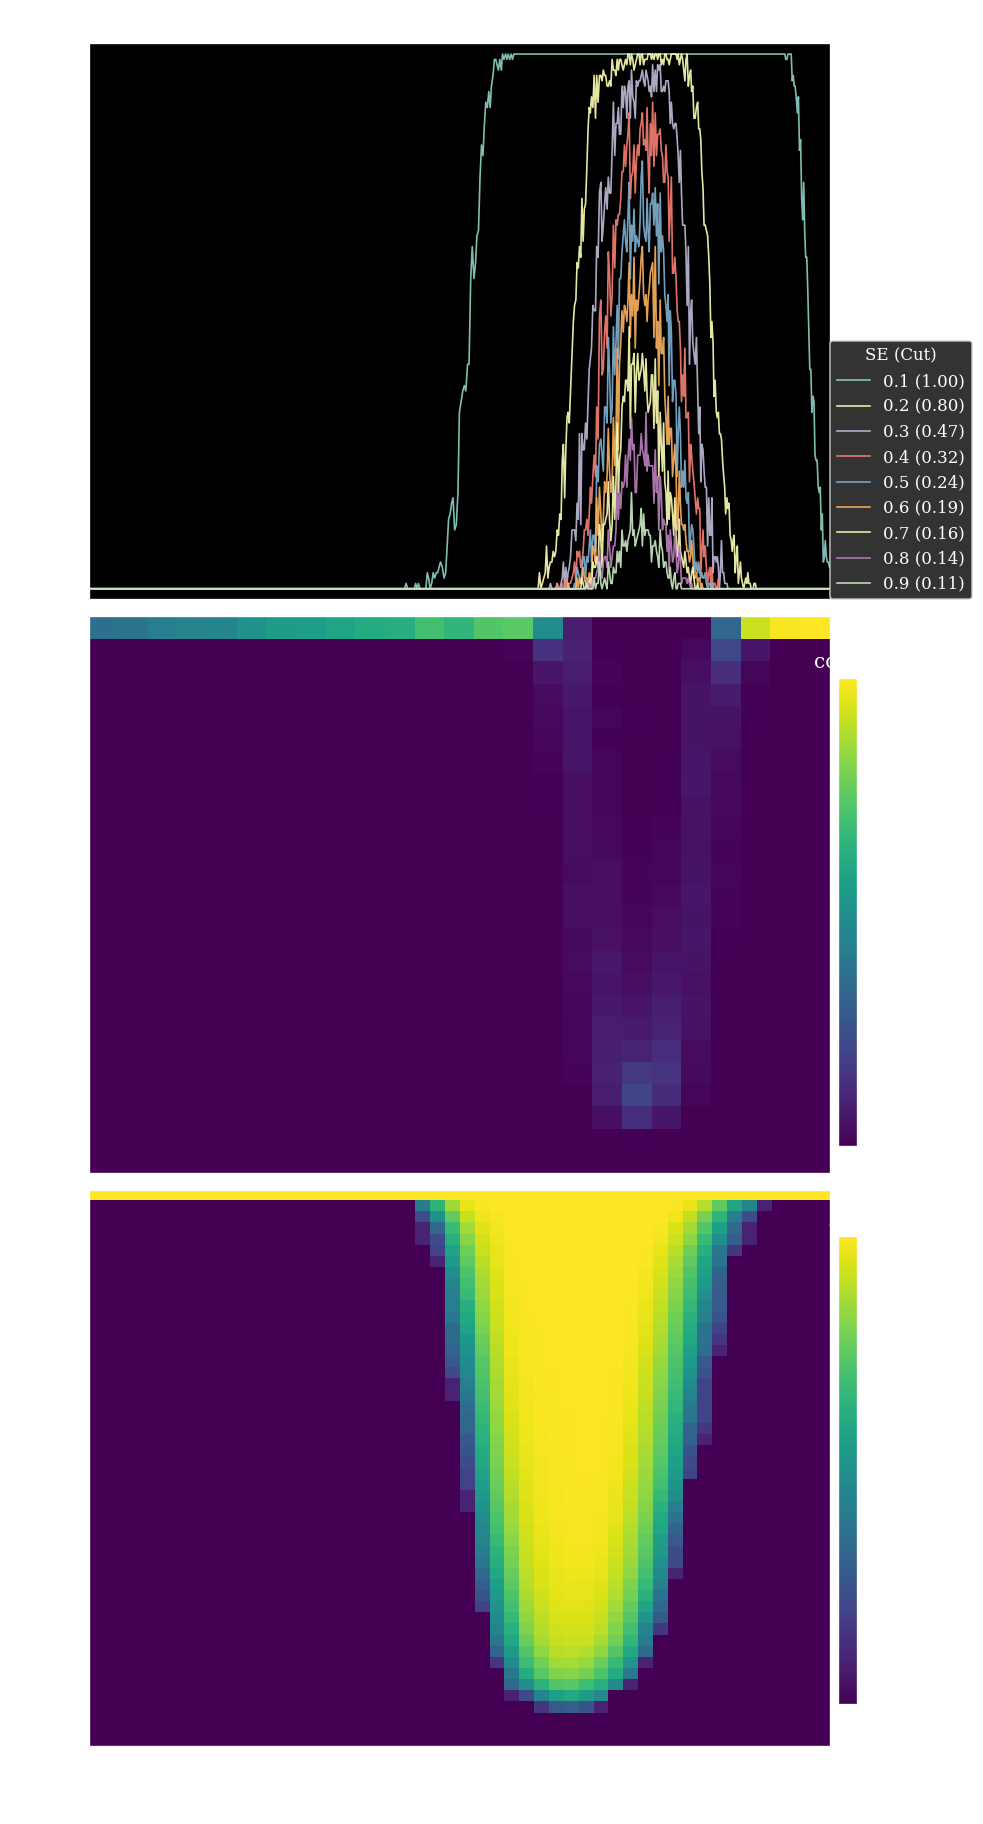

Entering Training...
Epoch:0001/0400  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2521, acc:50%, R50: 1.3102, 1/JSD: 2239.0583
Epoch:0100/0400  (76.3 s)
 Train: loss:0.5079, acc:49% || Val: loss: 0.4976, acc:50%, R50: 2.1579, 1/JSD: 698.3273
Epoch:0200/0400  (162.0s)
 Train: loss:0.2450, acc:75% || Val: loss: 0.2020, acc:76%, R50: 11.3352, 1/JSD: 111.3406
Epoch:0300/0400  (245.4s)
 Train: loss:0.2702, acc:74% || Val: loss: 0.2117, acc:75%, R50: 11.6373, 1/JSD: 103.1500
Epoch:0400/0400  (326.7s)
 Train: loss:0.2564, acc:74% || Val: loss: 0.2091, acc:75%, R50: 11.5970, 1/JSD: 103.6417


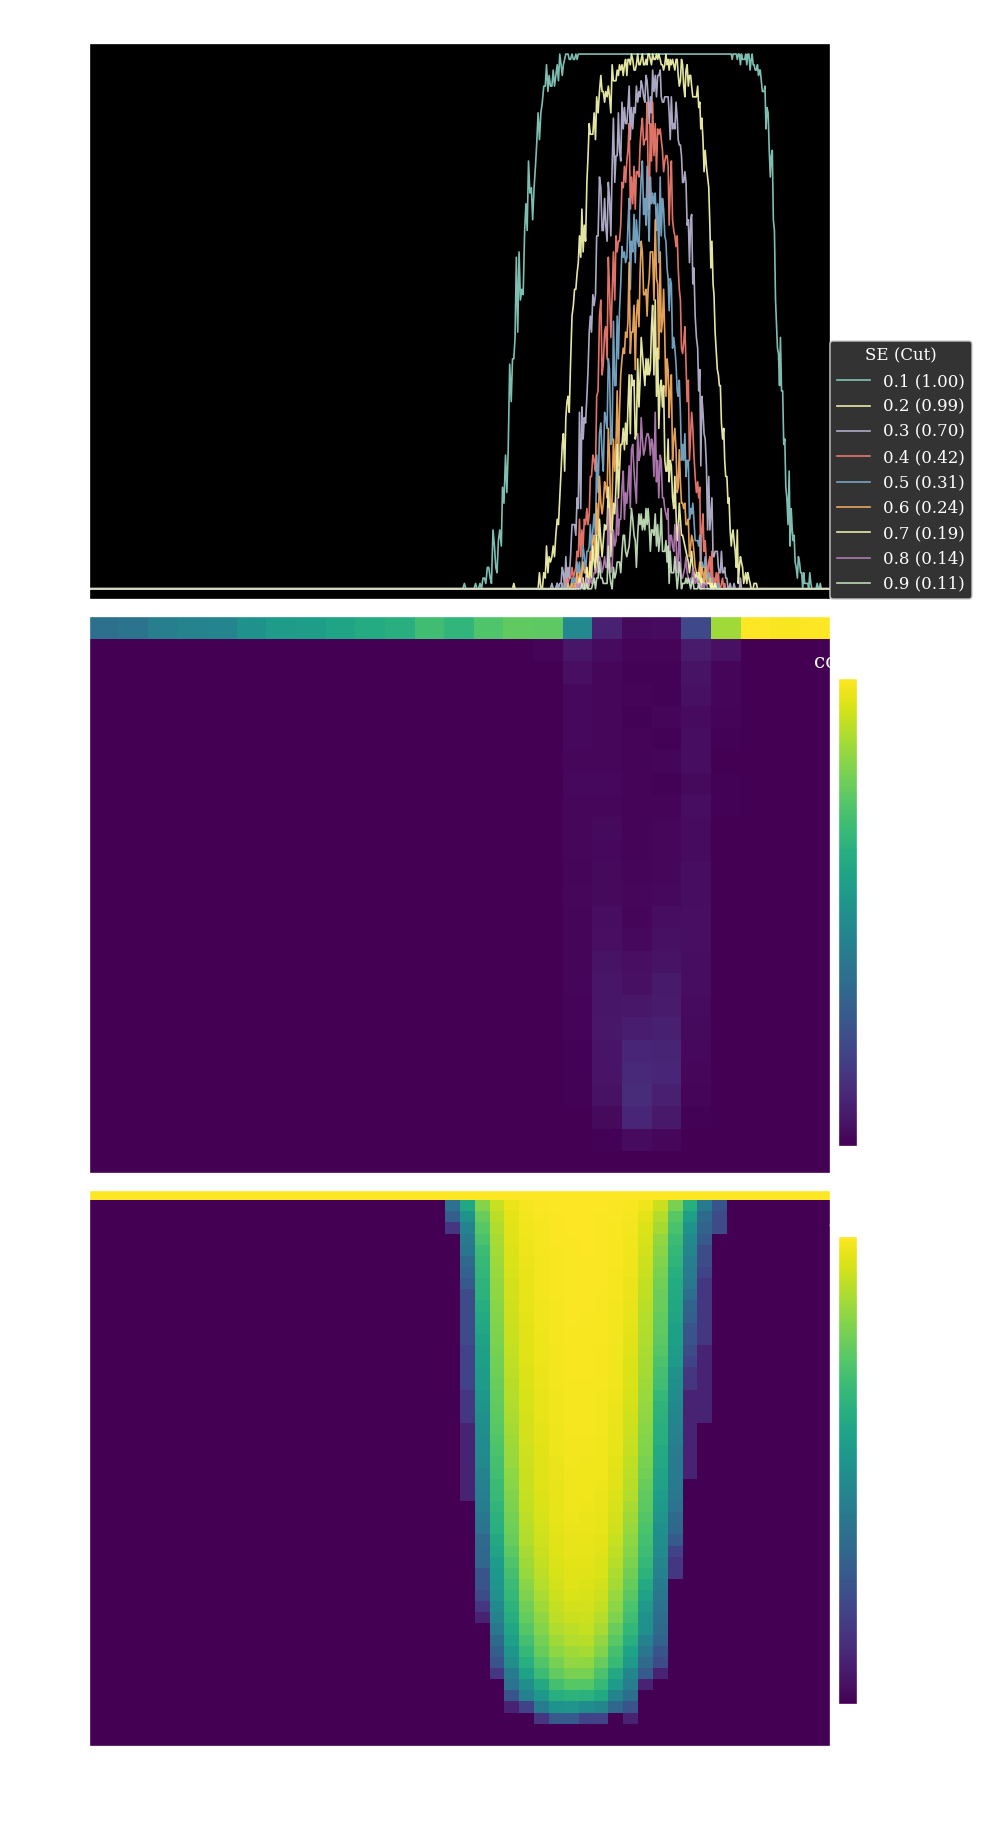

Entering Training...
Epoch:0001/0400  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2491, acc:48%, R50: 2.7538, 1/JSD: 138.7995
Epoch:0100/0400  (81.0 s)
 Train: loss:0.5108, acc:49% || Val: loss: 0.4978, acc:50%, R50: 1.8154, 1/JSD: 269.4106
Epoch:0200/0400  (161.1s)
 Train: loss:0.5080, acc:49% || Val: loss: 0.4978, acc:50%, R50: 1.8257, 1/JSD: 274.2884
Epoch:0300/0400  (247.5s)
 Train: loss:0.4749, acc:52% || Val: loss: 0.4978, acc:50%, R50: 1.8401, 1/JSD: 275.5453
Epoch:0400/0400  (329.5s)
 Train: loss:0.4924, acc:51% || Val: loss: 0.4978, acc:50%, R50: 1.8786, 1/JSD: 265.9533


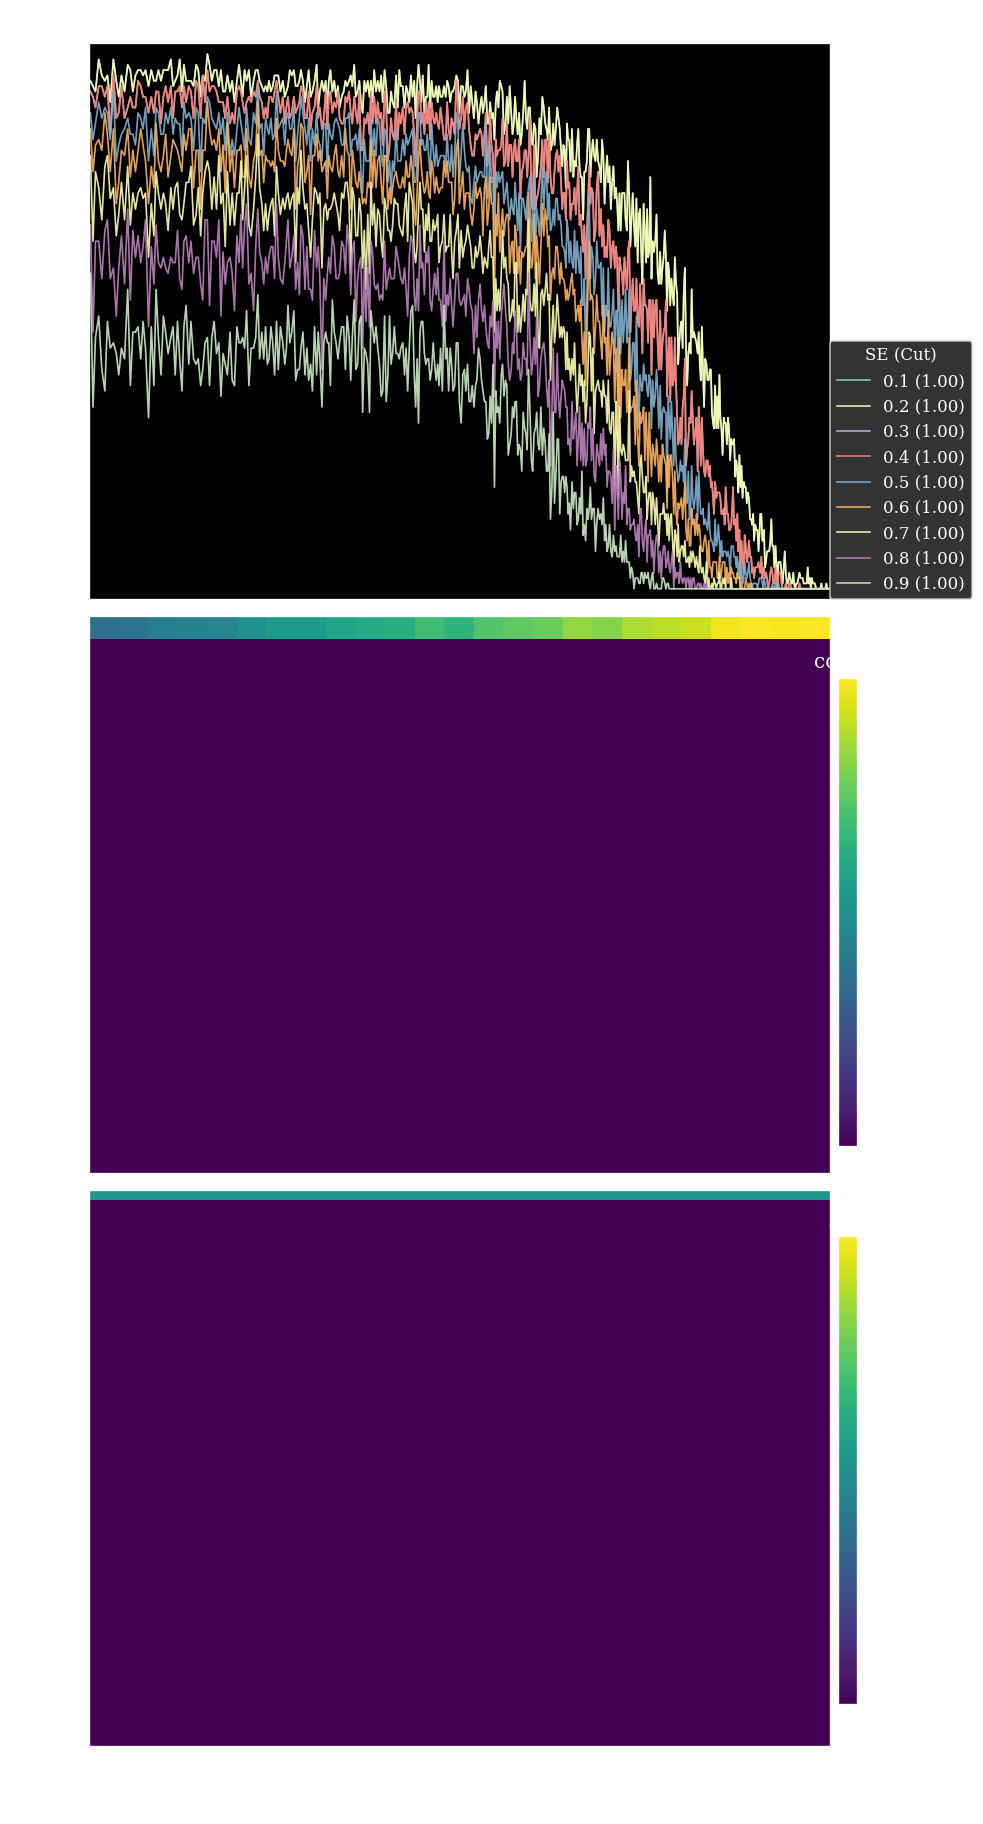

Entering Training...
Epoch:0001/0400  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2486, acc:56%, R50: 2.6492, 1/JSD: 108.3324
Epoch:0100/0400  (105.5s)
 Train: loss:0.4972, acc:50% || Val: loss: 0.4978, acc:50%, R50: 1.9199, 1/JSD: 300.9720
Epoch:0200/0400  (199.7s)
 Train: loss:0.4977, acc:50% || Val: loss: 0.4978, acc:50%, R50: 1.9746, 1/JSD: 452.1924
Epoch:0300/0400  (292.2s)
 Train: loss:0.4720, acc:53% || Val: loss: 0.4978, acc:50%, R50: 1.9915, 1/JSD: 429.4842
Epoch:0400/0400  (404.4s)
 Train: loss:0.4981, acc:50% || Val: loss: 0.4978, acc:50%, R50: 2.1246, 1/JSD: 334.9815


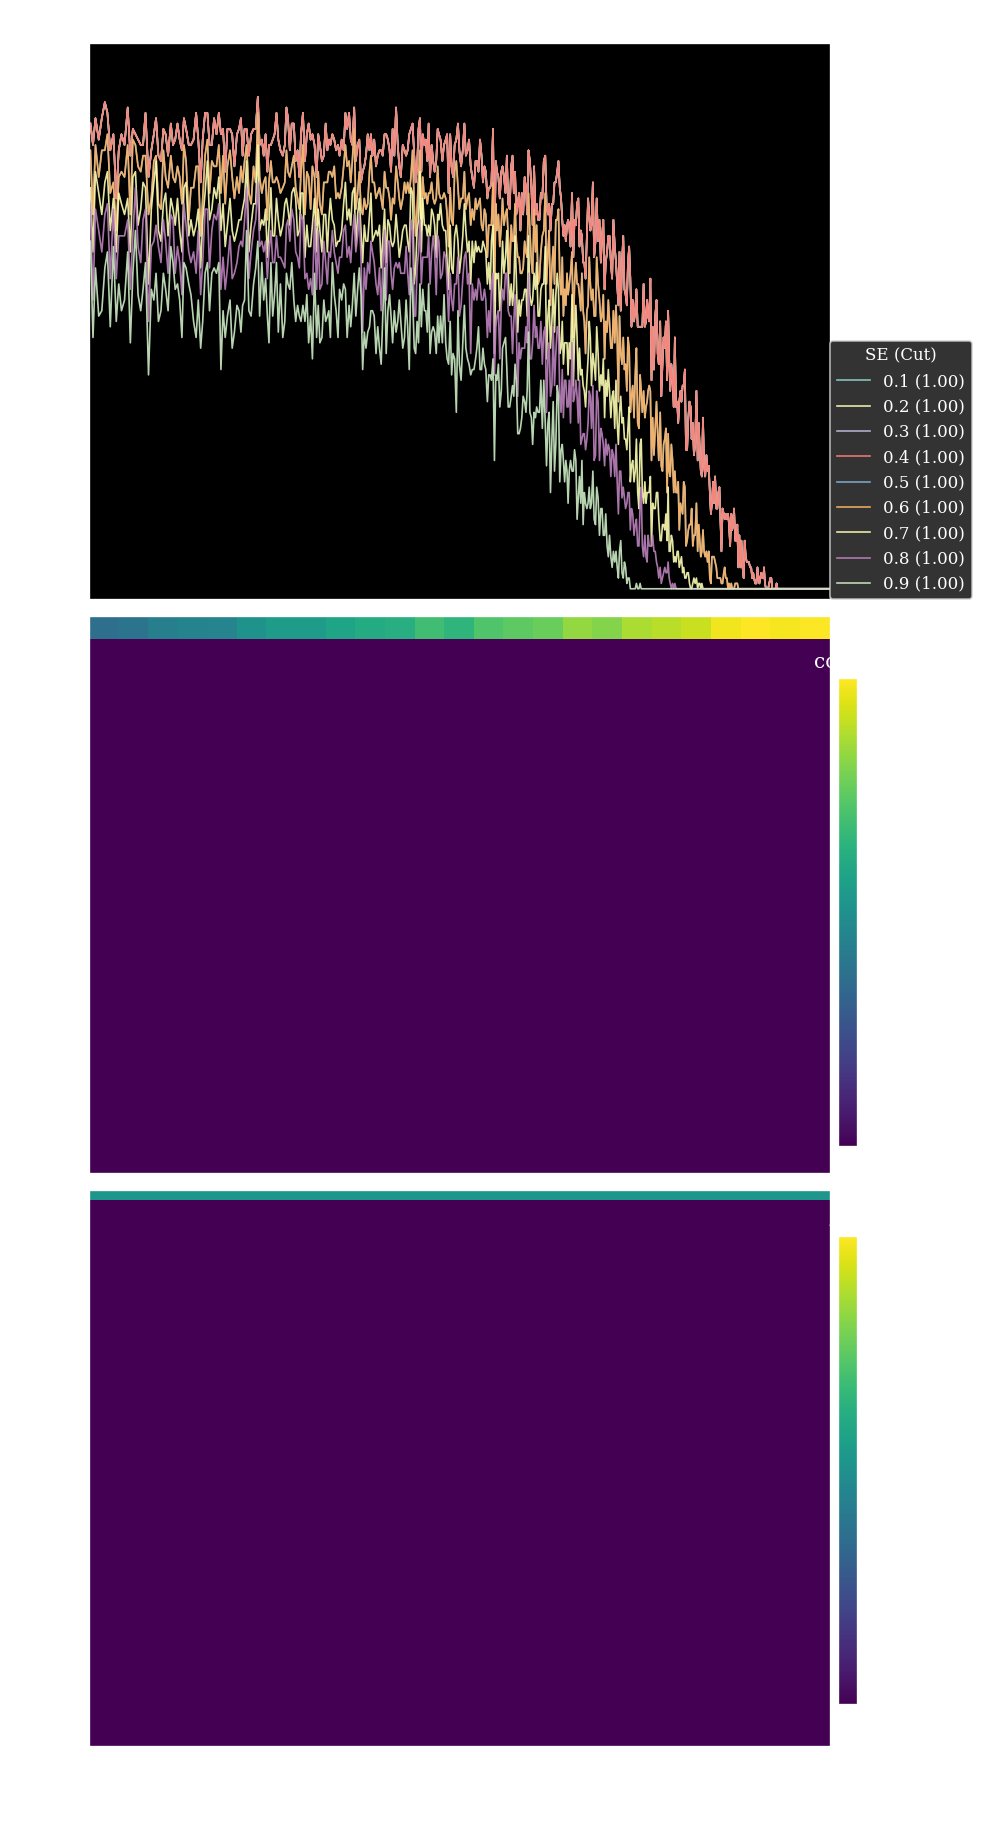

Entering Training...
Epoch:0001/0400  (0.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2502, acc:50%, R50: 2.3003, 1/JSD: 491.4737
Epoch:0100/0400  (97.4 s)
 Train: loss:0.5240, acc:47% || Val: loss: 0.4978, acc:50%, R50: 2.0631, 1/JSD: 415.0048
Epoch:0200/0400  (213.9s)
 Train: loss:0.4902, acc:51% || Val: loss: 0.4978, acc:50%, R50: 2.2353, 1/JSD: 353.3892
Epoch:0300/0400  (319.6s)
 Train: loss:0.4943, acc:50% || Val: loss: 0.4978, acc:50%, R50: 1.9569, 1/JSD: 288.8901
Epoch:0400/0400  (422.3s)
 Train: loss:0.4733, acc:52% || Val: loss: 0.4978, acc:50%, R50: 2.1152, 1/JSD: 402.3241


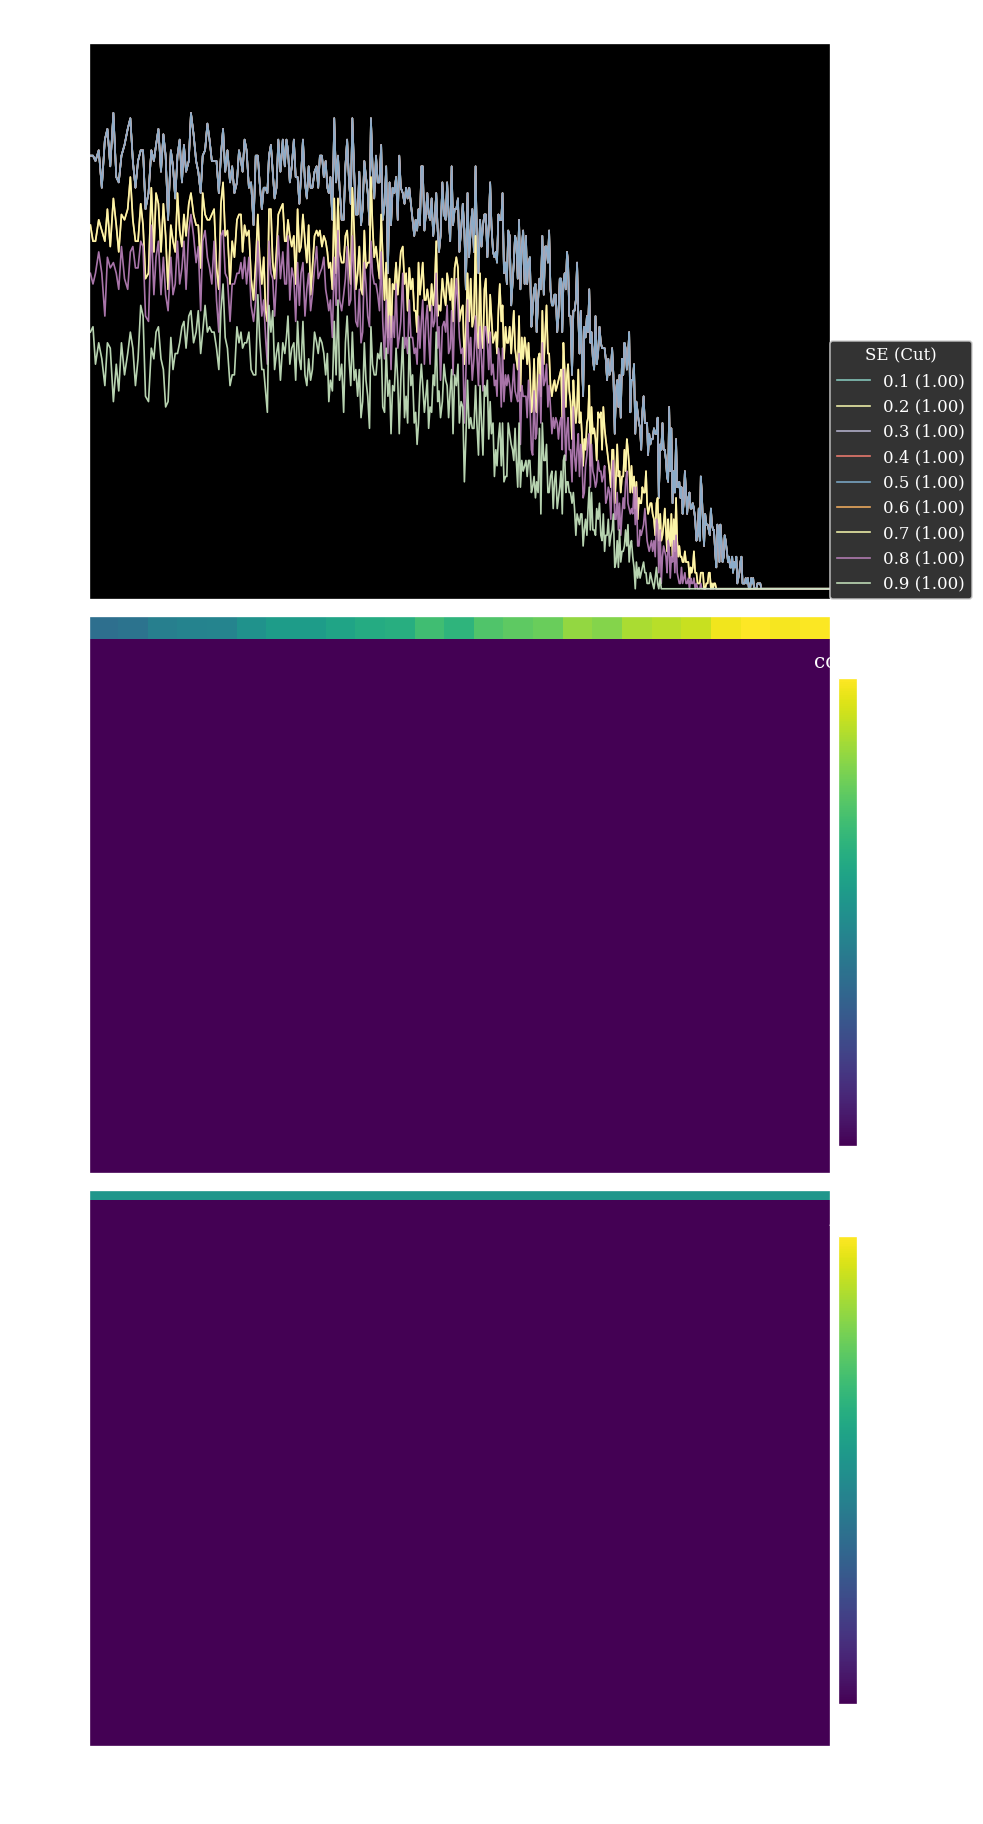

Entering Training...
Epoch:0001/0400  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2505, acc:50%, R50: 1.7466, 1/JSD: 8885.7311
Epoch:0100/0400  (104.4s)
 Train: loss:0.4864, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0400  (200.3s)
 Train: loss:0.5132, acc:48% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0400  (298.7s)
 Train: loss:0.4991, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0400/0400  (412.3s)
 Train: loss:0.5064, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


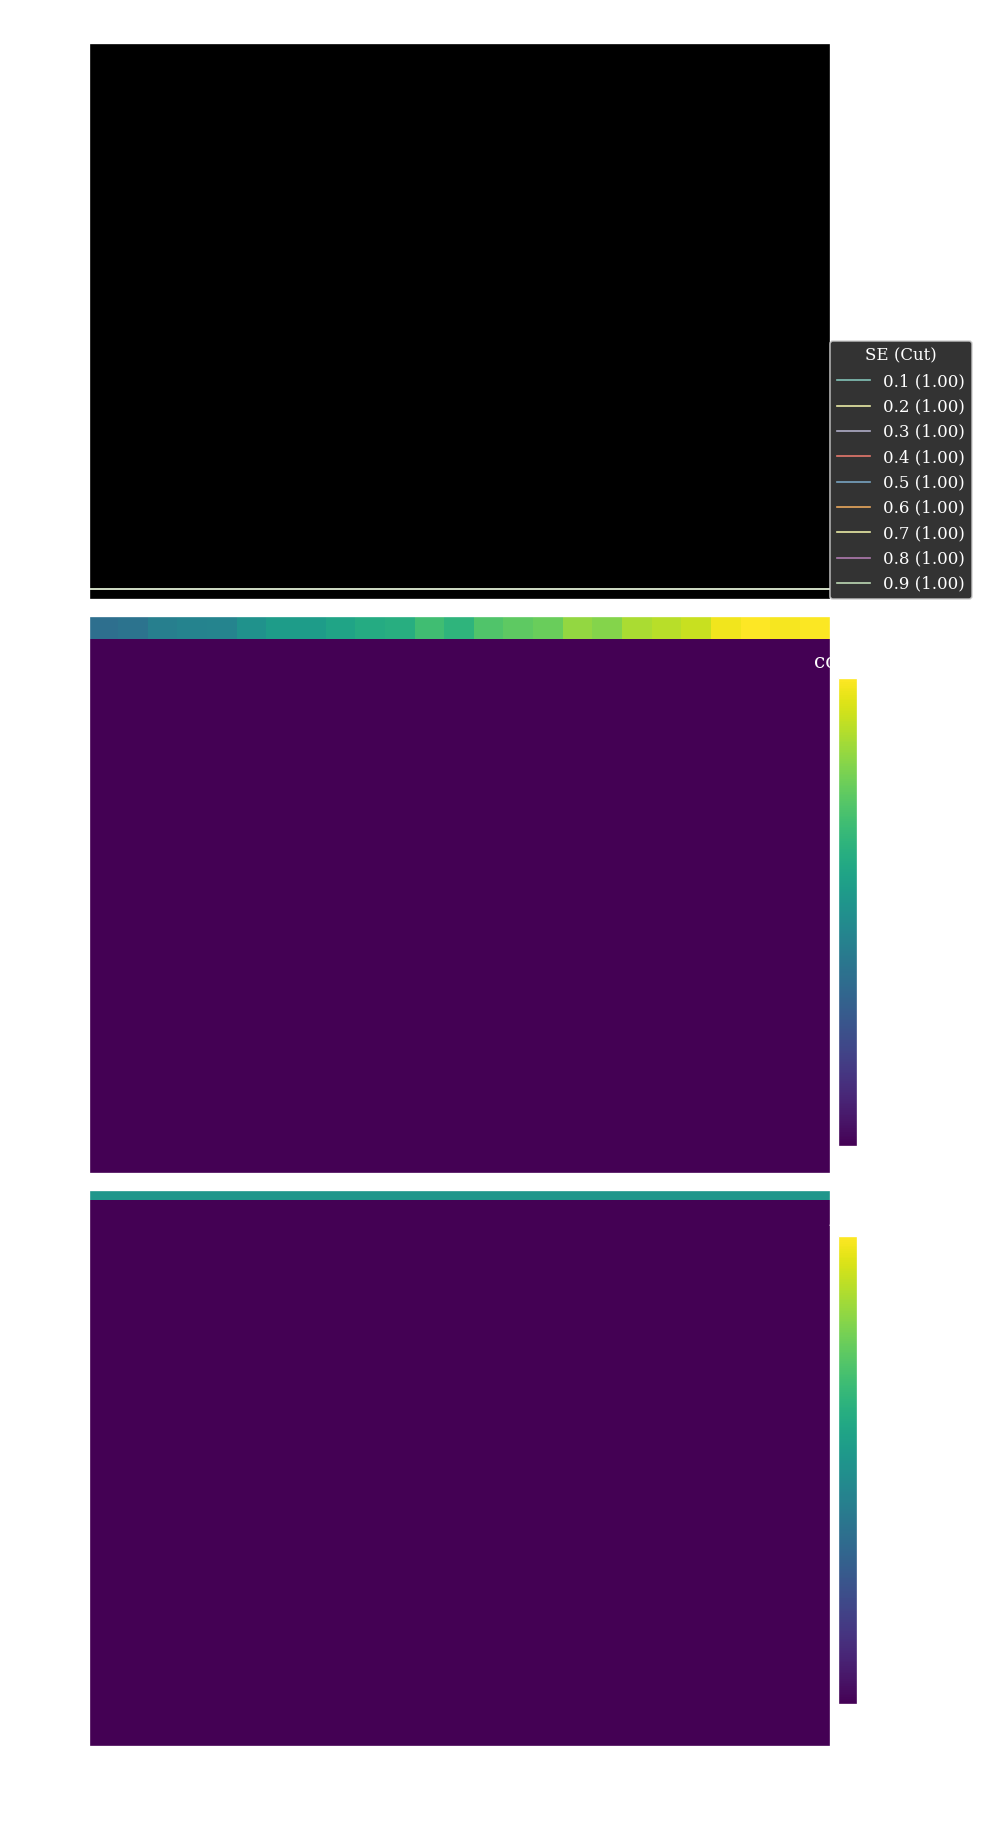

Entering Training...
Epoch:0001/0400  (0.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2481, acc:52%, R50: 3.0902, 1/JSD: 461.7114
Epoch:0100/0400  (98.4 s)
 Train: loss:0.4758, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0400  (211.0s)
 Train: loss:0.4963, acc:48% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0400  (302.4s)
 Train: loss:0.4652, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0400/0400  (396.1s)
 Train: loss:0.4766, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


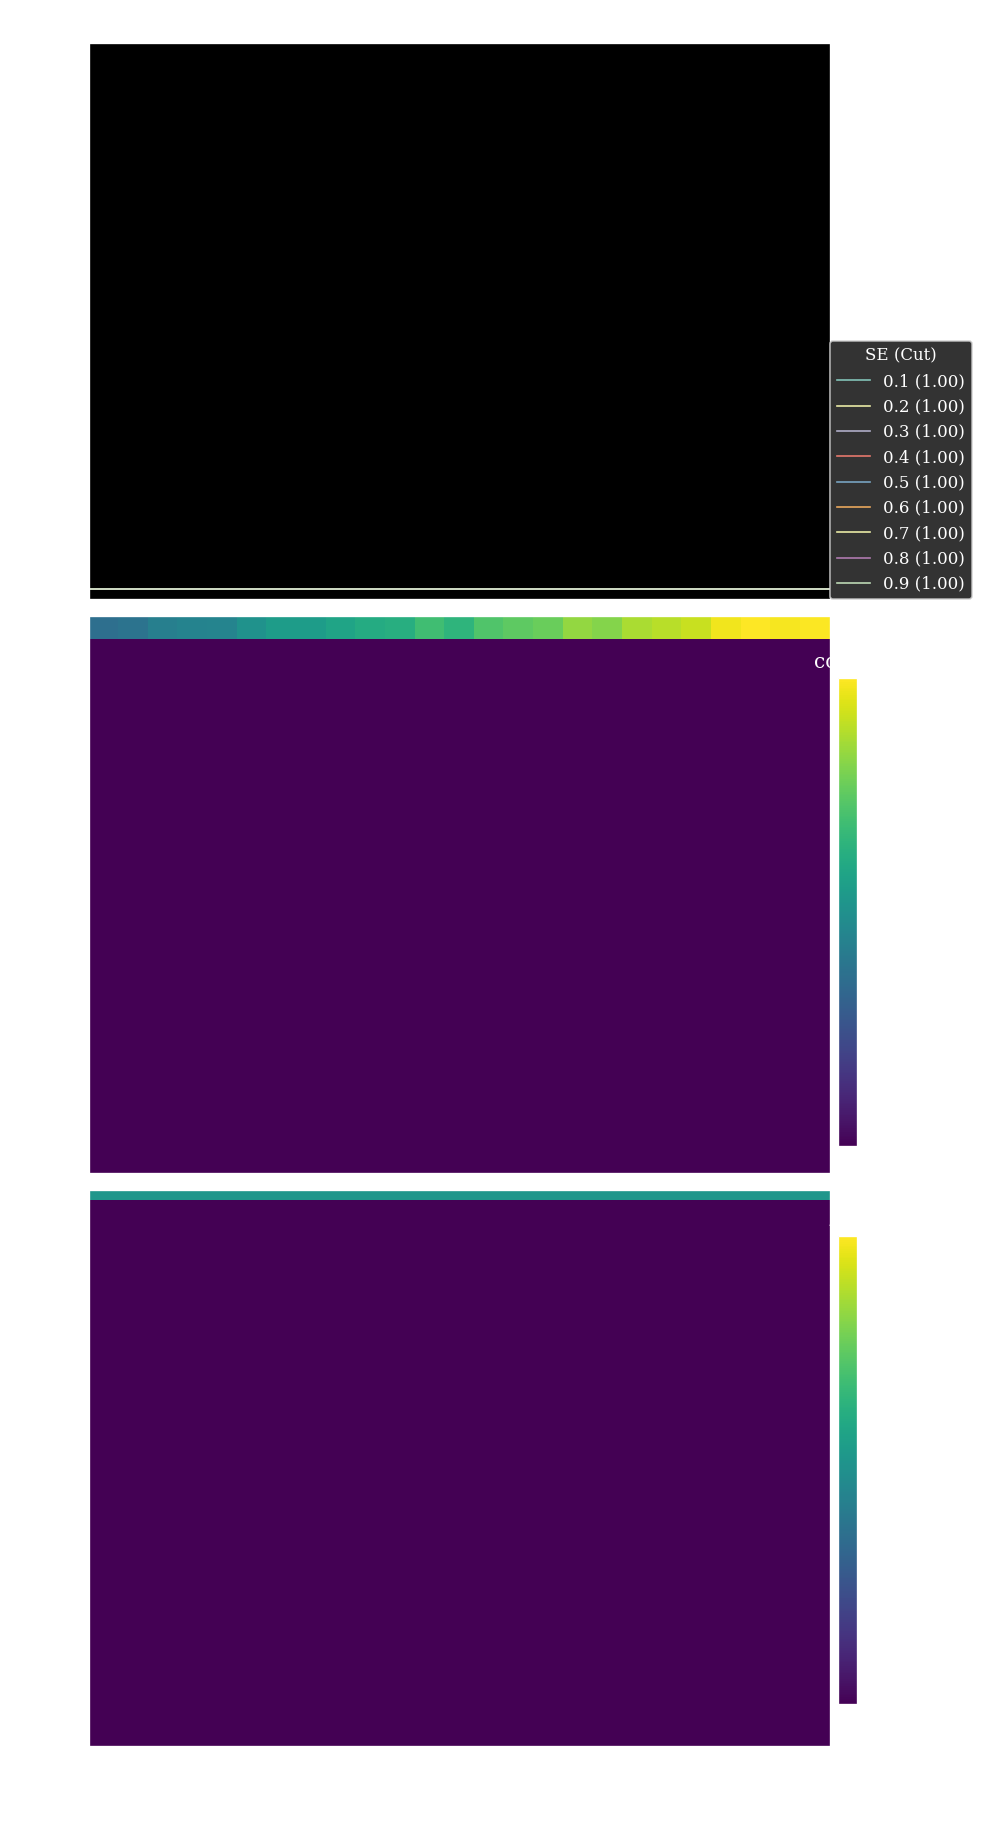

Entering Training...
Epoch:0001/0400  (0.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2502, acc:49%, R50: 2.1032, 1/JSD: 2680.9018
Epoch:0100/0400  (108.8s)
 Train: loss:0.4499, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0400  (213.6s)
 Train: loss:0.4516, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0400  (313.5s)
 Train: loss:0.4491, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0400/0400  (415.2s)
 Train: loss:0.4587, acc:50% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


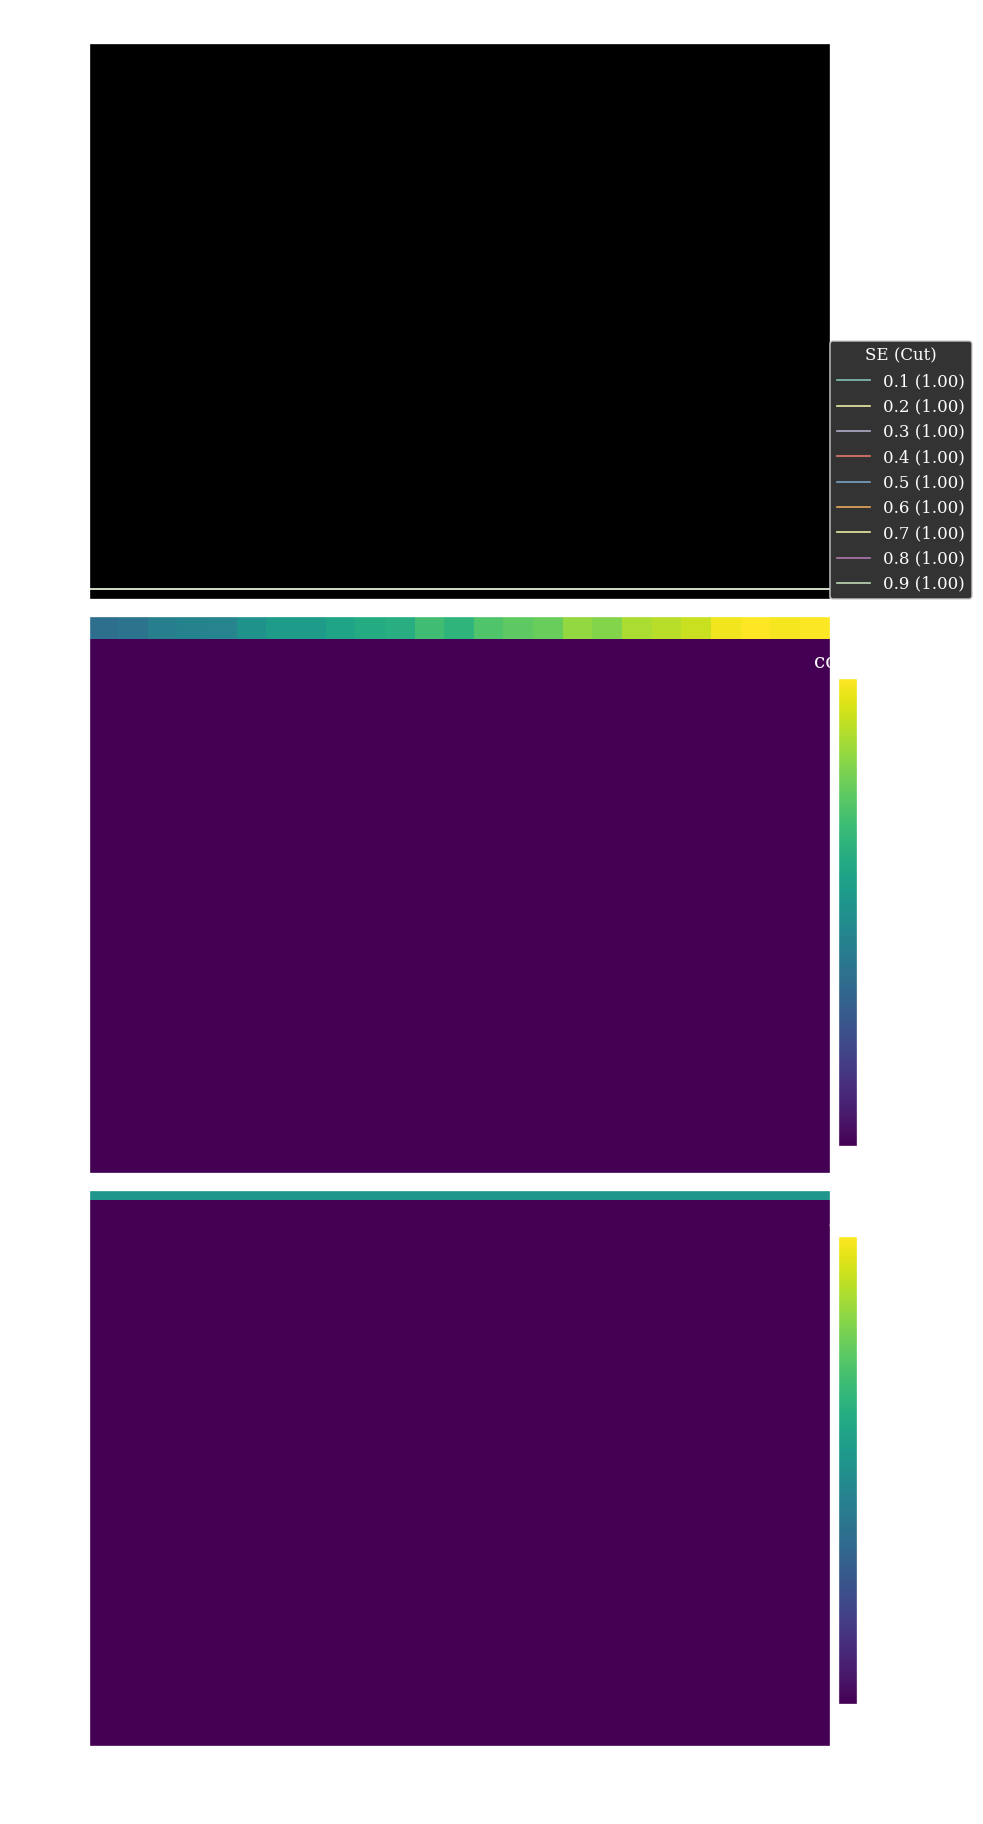

Entering Training...
Epoch:0001/0400  (0.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.2507, acc:50%, R50: 2.3866, 1/JSD: 12357.7793
Epoch:0100/0400  (100.8s)
 Train: loss:0.3419, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0200/0400  (208.2s)
 Train: loss:0.3462, acc:48% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0300/0400  (307.9s)
 Train: loss:0.3248, acc:51% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan
Epoch:0400/0400  (409.7s)
 Train: loss:0.3370, acc:49% || Val: loss: 0.4979, acc:50%, R50: inf, 1/JSD: nan


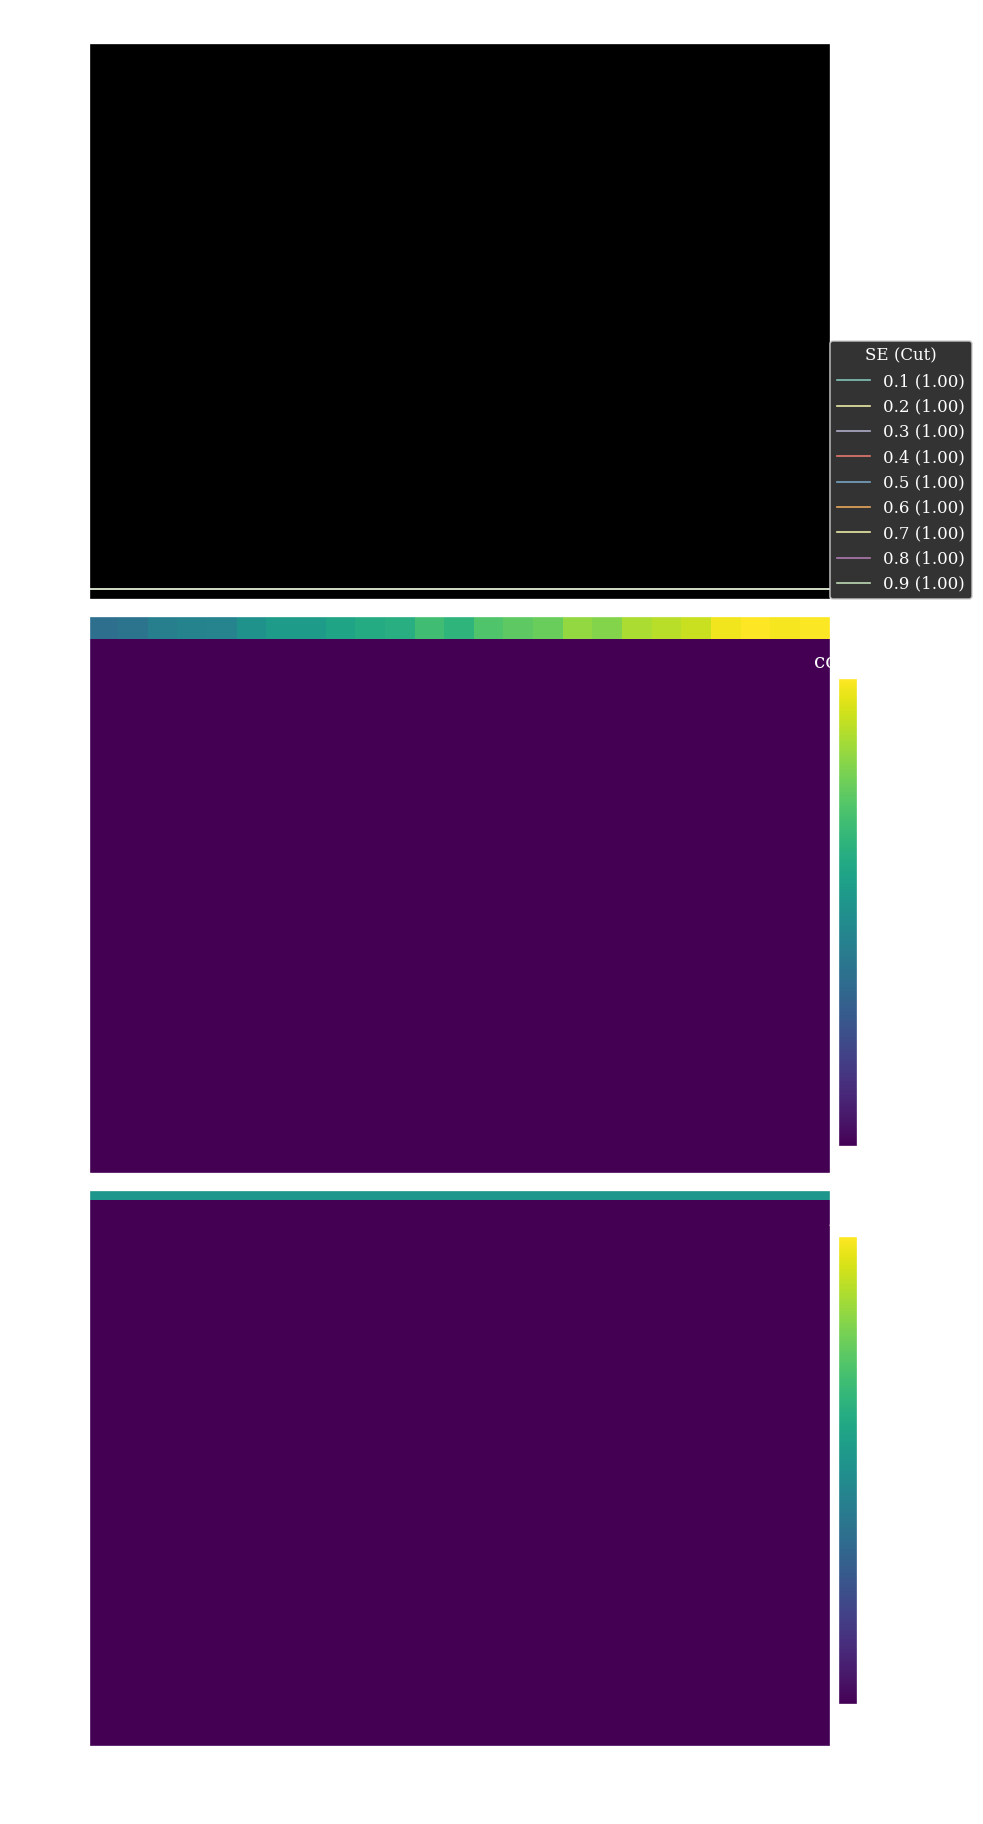

In [7]:
torch.manual_seed(69)
efficiencies = np.linspace(0.1,0.9,9)
for i,strength in enumerate([0,1e-4,3e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1]):
    if i==0 or i==1:
        params['epochs'] = 100
        lr = 1e-1
    else:
        params['epochs'] = 400
        lr = 2e-1
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=4).to(device)
    model_legendre.loss = FlatLoss(frac=frac,labels=y_train,bins=128,order=1,
                                   background_only=True,norm='L2',recalculate=True)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.SGD(model_legendre.parameters(),lr=lr,momentum=0.),
                       log=logger,
                       #scheduler=scheduler,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    
    
    scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02e}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
    cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
    cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
    cb.ax.set_title("counts")
    ax2.set_ylabel(r"$s$",fontsize=17)

    im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
    ax3.set_ylabel(r"$s$",fontsize=17)

    cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
    cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
    cb.ax.set_title(r"$F(s)$")
    ax3.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()